In [12]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
def f(x):
    return 18 * x - 12

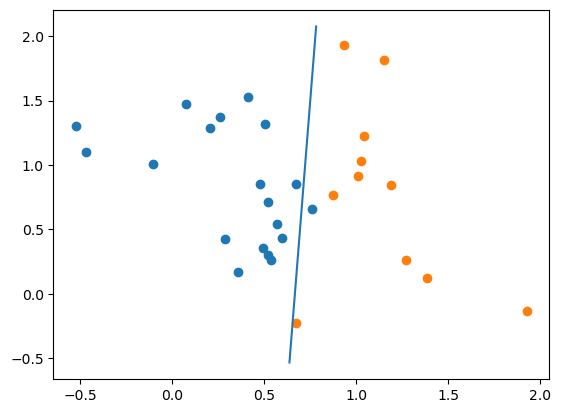

In [14]:
amount = 30
x_center, y_center = 0.694, 0.5
dist = 0.5
noise = 0.3

X_train = np.random.normal(x_center, dist, size=(amount, 2))
y_train = np.array([int(f(x[0]) > x[1])  for x in X_train])
X_train += (np.random.rand(amount, 2) - 0.5) * noise * 2
X_test = np.random.normal(x_center, dist, size=(amount, 2))
y_test = np.array([int(f(x[0]) > x[1])  for x in X_test])
X_test += (np.random.rand(amount, 2) - 0.5) * noise * 2

l_x = np.arange(0.667-0.03, 0.722+0.06, 0.001)
l_y = np.array([f(x) for x in l_x])
plt.scatter( X_train[y_train == 0][:, 0],  X_train[y_train == 0][:, 1])
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1])
plt.plot(l_x, l_y)
plt.show()

In [15]:
class LinearModel:
    
    
    def __init__(self):
        self.w = None
        self.lr = None
        self.lam = None
        self.n_input = None 
        
        
    def test(self, X_test, y_test):
        y_pred = []
        for _ in range(y_test.shape[0]):
            y_pred.append(np.argmax(model.predict_proba(X_test[_])))
        print(np.sum([1 for _ in range(len(y_pred)) if y_pred[_] == y_test[_]]) / len(y_pred))
        
        
    def fit(self, X_train, y_train, mode='online-learning', opt='const', lr=0.01, epoches=100, acc=1e-3, batch_size=4):
        
        self.lr = lr
        self.n_input = X_train.shape[1]
        self.epoches = epoches
        
        y_train = self.one_hot_binary(y_train)
        
        self.w = np.random.uniform(0, 1, (self.n_input + 1, 2))
                    
        probas = [self.predict_proba(_) for _ in X_train]
        y_preds = [np.array([1-np.argmax(_),0+np.argmax(_)]) for _ in probas]
        loss = [self.accurasy(y_train, y_preds)]
        
        if mode == 'online-learning' and opt == 'const':
            for ep in range(epoches):
                y_pred = np.empty((y_train.shape[0], 2), dtype=float)
                for i in range(len(X_train)):
                    proba = self.predict_proba(X_train[i])
                    y_pred[i] = np.array([1-np.argmax(proba),0+np.argmax(proba)])
                    self.w -= lr * self.grad(X_train[i], proba, y_train[i])
                loss.append(self.accurasy(y_train, y_pred))
                if loss[-1] >= acc:
                    break
        
        if mode == 'online-learning' and opt == 'adapted':
            for ep in range(epoches):
                y_pred = np.empty((y_train.shape[0], 2), dtype=float)
                for i in range(len(X_train)):
                    proba = self.predict_proba(X_train[i])
                    y_pred[i] = np.array([1-np.argmax(proba),0+np.argmax(proba)])
                    lr = 1 / (1 + np.sum(np.square(X_train[i])))
                    self.w -= lr * self.grad(X_train[i], proba, y_train[i])
                loss.append(self.accurasy(y_train, y_pred))
                if loss[-1] >= acc:
                    break
                    
        if mode == 'batch-learning' and opt == 'const':
            n = y_train.shape[0] // batch_size * batch_size
            for ep in range(epoches):
                y_pred = np.empty((y_train.shape[0], 2), dtype=float)
                for b in range(0, n, batch_size):
                    grad = np.zeros(self.w.shape, dtype=float)
                    for i in range(batch_size):
                        proba = self.predict_proba(X_train[b + i])
                        y_pred[b + i] = np.array([1-np.argmax(proba),0+np.argmax(proba)])
                        grad += self.grad(X_train[b + i], proba, y_train[b + i])
                    self.w -= lr * grad
                loss.append(self.accurasy(y_train, y_pred))
                if loss[-1] >= acc:
                    break
                    
        if mode == 'batch-learning' and opt == 'adapted':
            n = y_train.shape[0] // batch_size * batch_size
            for ep in range(epoches):
                y_pred = np.empty((y_train.shape[0], 2), dtype=float)
                for b in range(0, n, batch_size):
                    grad = np.zeros(self.w.shape, dtype=float)
                    toplr, bottomlr = 0, 0
                    for i in range(batch_size):
                        proba = self.predict_proba(X_train[b + i])
                        y_pred[b + i] = np.array([1-np.argmax(proba),0+np.argmax(proba)])
                        grad += self.grad(X_train[b + i], proba, y_train[b + i])
                        y = proba[np.argmax(y_train[b + i])] - np.argmax(y_train[b + i])
                        a = np.sum([y * (1 + X_train[b + i] * X_train[b + _]) for _ in range(batch_size)]) 
                        toplr += y * a
                        bottomlr += np.square(a)
                    lr = toplr / bottomlr
                    self.w -= lr * grad
                loss.append(self.accurasy(y_train, y_pred))
                if loss[-1] >= acc:
                    break
        
        plt.plot(np.arange(len(loss)), loss) 
        plt.show()  
        
        
    def one_hot_binary(self, y):
        return np.array([np.array([1-_, 0+_]) for _ in y])
        
        
    def accurasy(self, y, y_pred):
        return 1 - np.sum(np.sum([np.abs(np.argmax(y[i]) - np.argmax(y_pred[i])) for i in range(y.shape[0])])) / y.shape[0]
        
        
    def softmax(self, z):
        e = np.exp(z)
        sm = e / np.sum(e)
        return sm
    
    
    def predict_proba(self, X):
        if X.shape[0] < self.n_input + 1:
            X = np.concatenate((X, np.ones(1)), axis=0)
        return self.softmax(np.dot(X, self.w))
    
    
    def grad(self, X, proba, y):
        if X.shape[0] < self.n_input + 1:
            X = np.concatenate((X, np.ones(1)), axis=0)
        return (-1 / self.n_input) * np.dot(np.array([X]).T, np.array([(y - proba)]))
        
        
    def W(self):
        return self.w

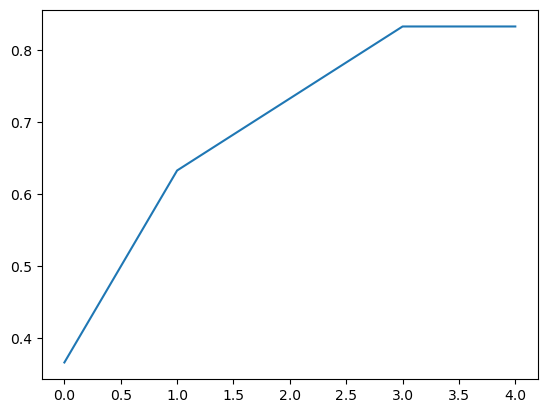

0.9


In [16]:
model = LinearModel()
model.fit(X_train, y_train, mode='online-learning', opt='const', lr=.2, epoches=4, acc=1)
model.test(X_test, y_test)

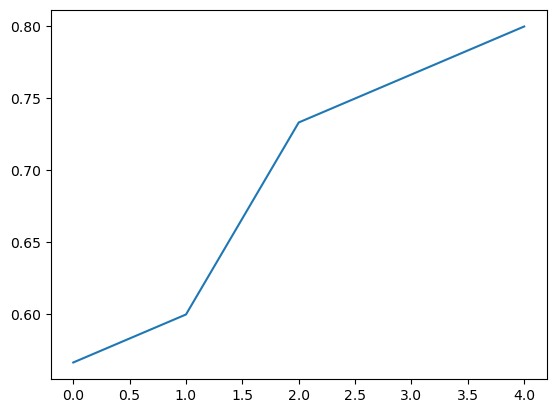

0.7333333333333333


In [17]:
model = LinearModel()
model.fit(X_train, y_train, mode='online-learning', opt='adapted', epoches=4, acc=1)
model.test(X_test, y_test)

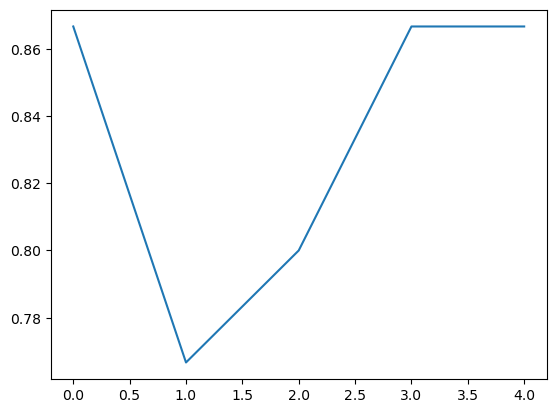

0.9


In [18]:
model = LinearModel()
model.fit(X_train, y_train, mode='batch-learning', opt='const', batch_size=4, lr=.2, epoches=4, acc=1)
model.test(X_test, y_test)

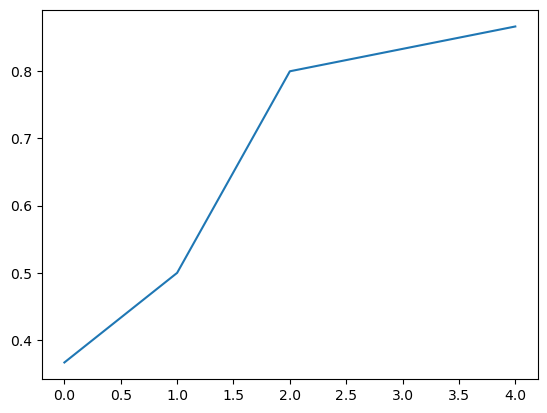

0.8666666666666667


In [19]:
model = LinearModel()
model.fit(X_train, y_train, mode='batch-learning', opt='adapted', batch_size=4, epoches=4, acc=1)
model.test(X_test, y_test)